In [1]:
import matplotlib.pyplot as plt

import tunable_correlation_difficulty as tcd

# Problem Description

The `tunable_correlation_difficulty` module contains the core parts of the temporal correlation stress test problem.  (The one Martha called "Kirby's problem."  The FTA paper sections 4 and 7 describes in more detail.)  The idea is that we want to fit a function $f: \mathbb{R} \to \mathbb{R}$ with a model $f_\theta: \mathbb{R} \to \mathbb{R}$ with training examples

$$
(X_t, Y_t)
$$

where $X_t$ are inputs and $Y_t$ are labels such that $E[Y_t | X_t] = f(X_t)$.  In ideal conditions, $(X_t)$ is an i.i.d. process, but the `tunable_correlation_difficulty` module has a sampling procedure for $(X_t)$ with tunable temporal correlation.  In particular, let our temporal correlation difficulty parameter be $d \in [0, 1]$.  With zero difficulty $d=0$, the process is i.i.d., so we are in ideal conditions.  With full difficulty $d=1$, the process is maximally correlated.

**The sequence of distributions $(X_t)$ is generated via the `tcd.get_distributions()` function.**

Importantly, the stationary distribution of process $(X_t)$ is invariant to difficulty $d$.  This allows fair comparison across difficulty values.  This also means that there is a meaningful test set to use, even though the problem is non-i.i.d..  In particular, the test set should be drawn from the stationary distribution.

**A test set can be drawn using the `tcd.sample_overall_stationary() function.**

In [2]:
 
# Get a sequence of distributions.  Each distribution can be called with an integer
# argument, which will return N samples from that distribution.  The difficulty
# argument is the temporal correlation difficulty described above.  The bound argument
# defines the stationary distribution: given an infinite trajectory of X_t, 95% of 
# samples will be within ±bound.

# The returned sequence of distributions will be made of contiguous segments of 
# identical distributions.  If you want a sequence of distributions with 5 segments
# of 10 distributions, so that you get 50 distributions in total, then you'd call
# the method with num_means = 5 and segment_length = 10.  If you wanted 25 segments
# of 2 distributions, you'd call with num_means = 25 and segment_length = 2.

distributions = tcd.get_distributions(
    num_means = 5,
    segment_length = 10,
    difficulty = 0.8,
    bound = 1,
)

# Each distribution is callable, and returns a sample from that distribution.
# As an example, we'll get 4 samples from the first distribution.
first_distribution = distributions[0]
first_distribution(4)


tensor([[ 0.0542],
        [-0.5278],
        [-0.1576],
        [-0.1340]])

Text(0.5, 0, 'Distribution number')

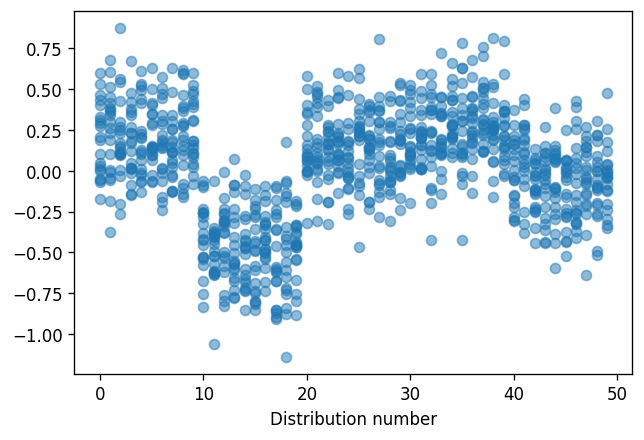

In [13]:
distributions = tcd.get_distributions(
    num_means = 5,
    segment_length = 10,
    difficulty = 0.8,
    bound = 1,
)

# Here we will draw a batch of 20 samples from each distribution.  Because we asked for
# segment_length = 10, we will see the first 10 batches appear similar, and then
# the next 10 will be centered around a different mean.  This will repeat as per 
# the num_means argument.abs

# Symbolically, the first 10 distributions will be identical: all Gaussian with the
# same mean and variance. Then the next distribution will have a new mean, which will
# persist for another 50 distributions.  This repeats 5 times:
# - distributions   0-9: N(m_0, v)
# - distributions 10-19: N(m_1, v)
# - ...
# - distributions 40-49: N(m_4, v)
#
# The variance per distribution 'v' depends on the magnitude of the high probability bound
# and on the correlation difficulty.  The sequence of means (m_t) is a first order 
# autoregressive process, which is why we are able to make guarantees about the 
# stationary distribution.

batch_size = 20
indices = []
samples = []
for k, distribution in enumerate(distributions):
    sample = distribution(batch_size)

    for x in sample.flatten():
        indices.append(k)
        samples.append(x.item())

plt.figure(figsize=(6, 4), dpi=120)
plt.scatter(indices, samples, alpha=0.5)
plt.xlabel('Distribution number')


# Play with the parameters to get a feel for what happens.

# Application in supervised learning

To use this in a supervised learning problem, we need our target function $f$ and a model to train $f_\theta$.

Here I'll reuse $f(x) = \sin(2 \pi x^2)$ and a `pytorch` neural network to fit the function.

In [18]:
import torch
import torch.nn.functional as F
from torch import nn

import numpy as np

from tqdm.notebook import tqdm

def target_function(domain_batch):
    # Normally one would see observation noise here, but the problem is hard
    # enough without it, so we don't introduce it as a confounding variable.
    return torch.sin(2 * np.pi * domain_batch ** 2)

def init_model_optimizer():
    # Networks 1-3 layers deep with a few tens of nodes per layer were 
    # reasonable in the FTA paper.
    model = nn.Sequential(
        nn.Linear(1, 50),
        nn.ReLU(),
        nn.Linear(50, 50),
        nn.ReLU(),
        nn.Linear(50, 50),
        nn.ReLU(),
        nn.Linear(50, 1)
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    return model, optimizer

def train(num_means, segment_length, difficulty, bound):
    distributions = tcd.get_distributions(
        num_means = num_means,
        segment_length = segment_length,
        difficulty = difficulty,
        bound = bound,
    )

    # Increasing batch size (per distribution) is another variable you can play with.
    # We found that increasing batch size helped mitigate interference effects due
    # to temporal correlation, which makes sense.
    batch_size = 10


    test_set_size = 500
    test_set = tcd.sample_overall_stationary(test_set_size, bound)

    model, optimizer = init_model_optimizer()

    elapsed_training_steps = []
    test_losses = []
    train_losses = []
    losses_buffer = []
    for step, distribution in enumerate(tqdm(distributions)):
        domain_sample = distribution(batch_size)
        target_values = target_function(domain_sample)

        optimizer.zero_grad()
        predicted_values = model(domain_sample)
        loss = F.mse_loss(predicted_values, target_values, reduction='mean')

        loss.backward()
        optimizer.step()

        losses_buffer.append(loss.item())

        # Record a test loss and a mean train loss 200 times throughout training.
        if len(losses_buffer) >= len(distributions) / 200:
            elapsed_training_steps.append(step)

            test_predicted_values = model(test_set)
            test_target_values = target_function(test_set)
            test_losses.append(F.mse_loss(test_predicted_values, test_target_values, reduction='mean'))

            train_losses.append(np.array(losses_buffer).mean())

            losses_buffer = []

    return elapsed_training_steps, test_losses, train_losses

def plot_results(elapsed_training_steps, test_losses, train_losses, difficulty):
    plt.figure(figsize=(6,4), dpi=120)
    plt.plot(elapsed_training_steps, train_losses, label='train loss')
    plt.plot(elapsed_training_steps, test_losses, label='test loss')
    plt.xlabel('Elapsed training steps')
    plt.ylabel('MSE loss')
    plt.ylim((0, 0.25))
    plt.title(f'Difficulty $d={difficulty:0.2f}$')
    plt.legend()

## Train on difficulty $d=0$ (i.i.d.) data

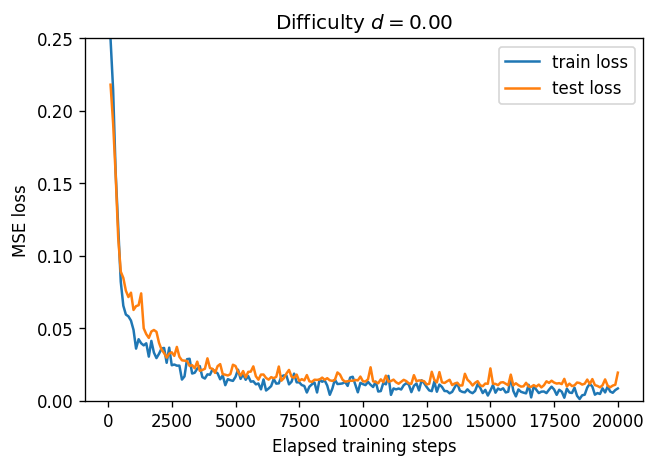

In [19]:
difficulty = 0
elapsed_training_steps, test_losses, train_losses = train(
    num_means = 50,
    segment_length = 400,
    difficulty = difficulty,
    bound = 1,
)
plot_results(elapsed_training_steps, test_losses, train_losses, difficulty)

## Train on difficulty $d=0.3$  data

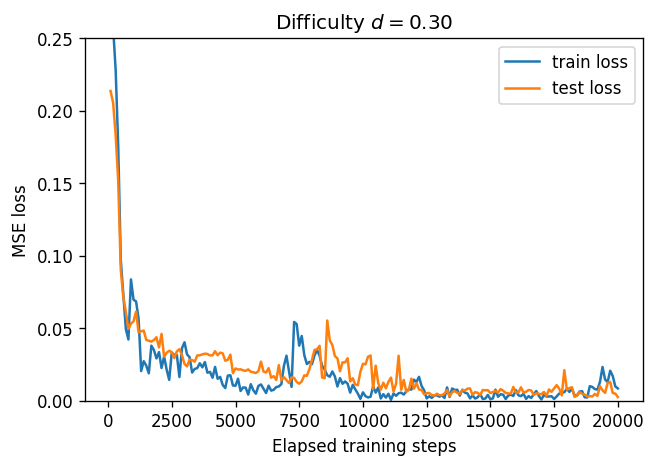

In [20]:
difficulty = 0.3
elapsed_training_steps, test_losses, train_losses = train(
    num_means = 50,
    segment_length = 400,
    difficulty = difficulty,
    bound = 1,
)
plot_results(elapsed_training_steps, test_losses, train_losses, difficulty)

## Train on  difficulty $d=0.5$ data

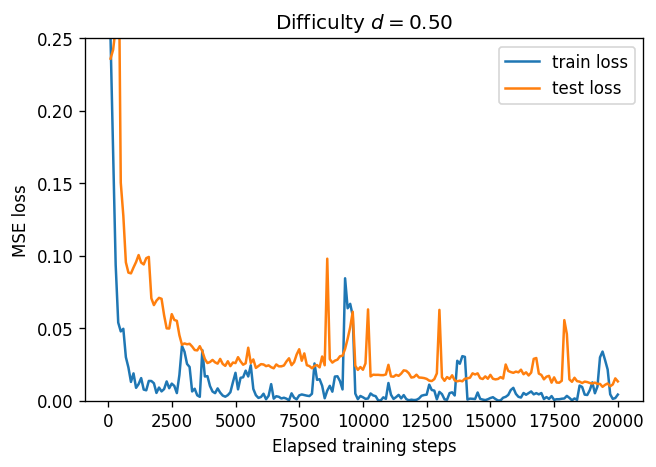

In [21]:
difficulty = 0.5
elapsed_training_steps, test_losses, train_losses = train(
    num_means = 50,
    segment_length = 400,
    difficulty = difficulty,
    bound = 1,
)
plot_results(elapsed_training_steps, test_losses, train_losses, difficulty)

## Train on difficulty $d= 0.8 $ data

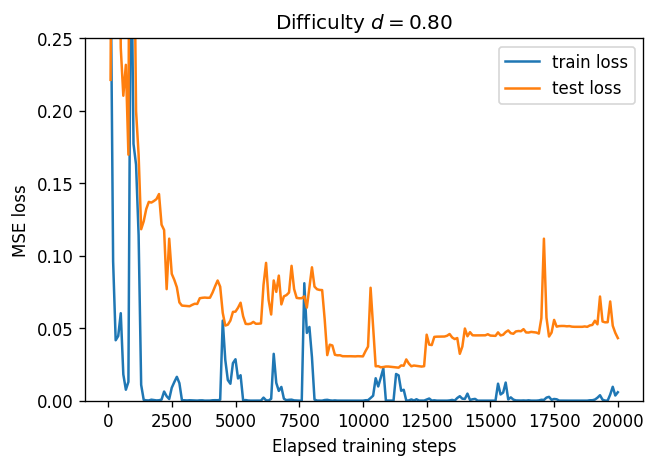

In [22]:
difficulty = 0.8
elapsed_training_steps, test_losses, train_losses = train(
    num_means = 50,
    segment_length = 400,
    difficulty = difficulty,
    bound = 1,
)
plot_results(elapsed_training_steps, test_losses, train_losses, difficulty)

As you can see, the model and the optimizer struggle a lot on higher difficulties.  But better techniques can deal with this well :)

Also, the environment is quite stochastic.  Remember, the universe wants you to do more than 3 runs.